In [1]:
%matplotlib inline
import numpy as np
import re
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_listing = pd.read_csv('data/listing_cleansed.csv')
df_listing = df_listing[df_listing.text_language=='en']
df_listing = df_listing[(df_listing.reviews_per_month>1)&(df_listing.number_of_reviews>4)]

In [3]:
cols_text =[col for col in df_listing.columns if 'text' in col]
cols_of_interest = ['id','review_scores_rating','availability_90']+cols_text
df_listing = df_listing[cols_of_interest]

In [4]:
df_listing.head()

,id,review_scores_rating,availability_90,text_name,text_summary,text_space,text_description,text_experiences_offered,text_neighborhood_overview,text_notes,text_transit,text_access,text_interaction,text_house_rules,text_host_about,text_language
11,15855185,88.0,0,Cozy and lovely apartment,"It's a nice small apartment, a little bit away...",It's my first apartment and I like it really m...,Man kann direkt vor der Tür kostenlos parken. ...,none,NaN,NaN,Man kann direkt vor der Tür kostenlos parken. ...,"There is a small balcony in front, it is nice ...",NaN,No smoking inside the apartment No party's N...,NaN,en
18,768616,98.0,7,Over the roofs of Berlin with Lift,NaN,Over the roofs of Berlin with lift and a great...,Over the roofs of Berlin with lift and a great...,none,NaN,NaN,The nearest train station and tram station is ...,"Iron and ironing board, well equipped kitchen ...","During your stay, I am always available for yo...","SMOKING Non smoking apartment, but allowed on ...",Hallo. Als Gastgeber ist es mir besonders wich...,en
19,14542554,100.0,56,Charming apartment in Prenzlauerberg,"Prenzlauerberg is a central district, from whe...","Die Wohnung ist ca. 60 qm groß. 2-Zimmer, Küch...","Prenzlauerberg is a central district, from whe...",none,NaN,NaN,"S-Bahn Prenzlauer Allee (Ringbahn S41/24, dire...",NaN,For questions or any advices I will be availab...,NaN,NaN,en
25,11381321,80.0,16,Cozy studio in Prenzlauer Berg,This cozy studio in a 19th century house in Pr...,This 20qm space is perfect for for couples and...,This cozy studio in a 19th century house in Pr...,none,"Prenlzlauer Berg is a great with many cafes, b...",Please notice that the flat is on the ground f...,You can reach the apartment with: S-Bahn lines...,You have a small kitchen with all need equipme...,I have a key box for Check-In and Check-Out. B...,Please wash your dishes and though away the ga...,NaN,en
35,2281634,98.0,18,Cozy apartment in Prenzlauer Berg,Studio flat for 1 or 2 guests located in one ...,The apartment is quiet and (URL HIDDEN) is loc...,Studio flat for 1 or 2 guests located in one ...,none,The apartment is located in one of the most be...,NaN,Around my place you can have delicious food an...,Fully equipped kitchen,I will be not in the apartment during my guest...,Please: - Do not use the internet provided at ...,I am 36 years old and I have a full time job t...,en


In [5]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data[df_missing_data.missing_percent>0]

,missing_percent
text_notes,54.014599
text_access,43.126521
text_interaction,41.727494
text_neighborhood_overview,36.922141
text_host_about,33.637470
text_transit,29.136253
text_house_rules,26.216545
text_space,15.328467
text_summary,7.360097
text_name,0.304136


In [21]:
df_listing = df_listing[(~df_listing.text_name.isnull())& (~df_listing.review_scores_rating.isnull())]
df_listing[cols_text] = df_listing[cols_text].astype(str)
df_listing['text_all'] =df_listing[cols_text].apply(lambda x: ' '.join(x), axis=1)
df_listing['text_all'] =df_listing.text_all.str.replace(r'[^a-zA-Z\d\s:]','')

In [7]:
df_listing = df_listing[df_listing.text_all.str.len()>3]


In [8]:
stringo = df_listing.text_all.tail(-1).values
print stringo

['Over the roofs of Berlin with Lift'
 'Charming apartment in Prenzlauerberg' 'Cozy studio in Prenzlauer Berg'
 ..., 'Beautiful and cozy apartment in Wedding'
 'Spacious light flat in Berlins North'
 'Near northside Berlin 15 mins to centre']


In [9]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

nltk.download('stopwords')

stop = stopwords.words('english')

raw_text = df_listing.text_all.values

vectorizer = TfidfVectorizer(ngram_range=(1,1),tokenizer=tokenizer_porter,stop_words=stop,max_features=20000)
X_vectorized = vectorizer.fit_transform(raw_text)

[nltk_data] Downloading package stopwords to /home/ramon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
freqs = [(word, X_vectorized.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
#sort from largest to smallest
pd.DataFrame(sorted (freqs, key = lambda x: -x[1])).head()

,0,1
0,apart,120.240257
1,berlin,88.096523
2,central,64.307251
3,flat,63.322684
4,studio,50.104840


In [1]:
idf = vectorizer.idf_
df_tfidf = pd.DataFrame.from_dict(dict(zip(vectorizer.get_feature_names(), idf)),orient='index')
df_tfidf.columns=['TFIDF']
df_tfidf.sort_values(by='TFIDF',ascending=False)

NameError: name 'vectorizer' is not defined

In [12]:
X_vectorized.shape

(1638, 1356)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_vectorized,df_listing.availability_90.values,test_size=.2)


In [14]:
lm = LinearRegression()
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
r2_score(y_test,prediction)

-0.64002871272750794

In [15]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)
r2_score(y_test,prediction)

-0.23808218632441003

From the **lack of correlation**, we can drop the text field of the listing description from the predictors.

### Worldcloud

In [28]:
text = df_listing.text_all.str.cat(sep=' ').replace('nan','').replace('none','')

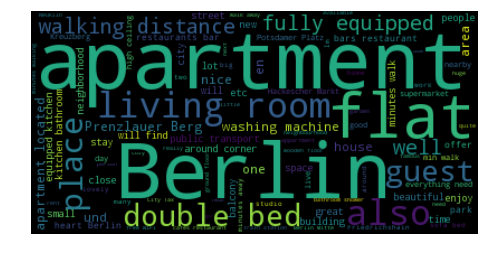

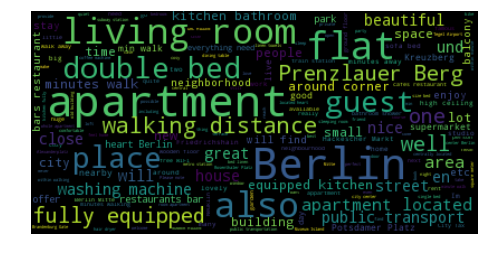

In [29]:
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud().generate(text)


# Display the generated image:
# the matplotlib way:

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()